# A Tour of TensorFlow Probability

https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/A_Tour_of_TensorFlow_Probability.ipynb


In [1]:
# Dependencies & Prerequisites

#@title Import { display-mode: "form" }

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

import collections
collections.Iterable = collections.abc.Iterable

In [2]:
print(f'tf version: {tf.__version__}')
print(f'tfp version: {tfp.__version__}')

tf version: 2.9.2
tfp version: 0.14.0


In [3]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))

# Preamble: TensorFlow


## Vectorization

In [4]:
mats = tf.random.uniform(shape=[100, 10, 10])
vecs = tf.random.uniform(shape=[100, 10, 1])

def for_loop_solve():
  return np.array(
    [tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(100)])

def vectorized_solve():
  return tf.linalg.solve(mats, vecs)

# Vectorization for the win!
%timeit for_loop_solve()
%timeit vectorized_solve()

Metal device set to: Apple M1 Pro


2022-08-25 14:52:54.220419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 14:52:54.220667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


176 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
133 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Hardware Acceleration

In [5]:
# Code can run seamlessly on a GPU, just change Colab runtime type
# in the 'Runtime' menu.
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

Using a GPU


2022-08-25 14:53:07.148667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 14:53:07.148686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Automatic Differentiation

In [6]:
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
  tape.watch([a, b])
  c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])

tf.Tensor(3.1415925, shape=(), dtype=float32)
tf.Tensor(2.7182815, shape=(), dtype=float32)


# TensorFlow Probability
TensorFlow Probability is a library for probabilistic reasoning and statistical analysis in TensorFlow.
We support modeling, inference, and criticism through composition of low-level modular components.

## Low-level building blocks
* Distributions
* Bijectors

## High(er)-level constructs
* Markov chain Monte Carlo
* Probabilistic Layers
* Structural Time Series
* Generalized Linear Models
* Optimizers

# Distributions
A tfp.distributions.Distribution is a class with two core methods: sample and log_prob.

TFP has a lot of distributions!

In [7]:
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchBroadcast, BatchConcat, BatchReshape, Bates, Bernoulli
Beta, BetaBinomial, BetaQuotient, Binomial, Blockwise, Categorical, Cauchy, Chi
Chi2, CholeskyLKJ, ContinuousBernoulli, DeterminantalPointProcess, Deterministic
Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell, Empirical
ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, LambertWDistribution
LambertWNormal, Laplace, LinearGaussianStateSpaceMod

# A simple scalar-variate Distribution

In [8]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

AttributeError: module 'collections' has no attribute 'Sequence'

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


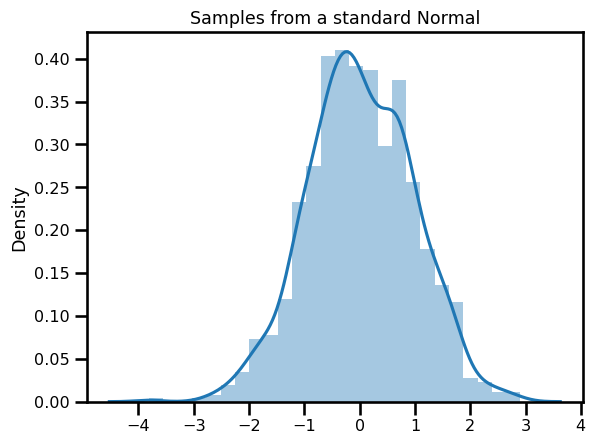

In [9]:
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

In [10]:
# Compute the log_prob of a point in the event space of `normal`
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [11]:
# Compute the log_prob of a few points
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

# Distributions and Shapes
Numpy ndarrays and TensorFlow Tensors have shapes.

TensorFlow Probability Distributions have shape semantics -- we partition shapes into semantically distinct pieces, even though the same chunk of memory (Tensor/ndarray) is used for the whole everything.

* Batch shape denotes a collection of Distributions with distinct parameters
* Event shape denotes the shape of samples from the Distribution.
We always put batch shapes on the "left" and event shapes on the "right".

# A batch of scalar-variate Distributions

In [12]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [13]:
# Samples' shapes go on the left!
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


In [14]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]

lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)

Broadcast log_prob shape: (200, 3)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


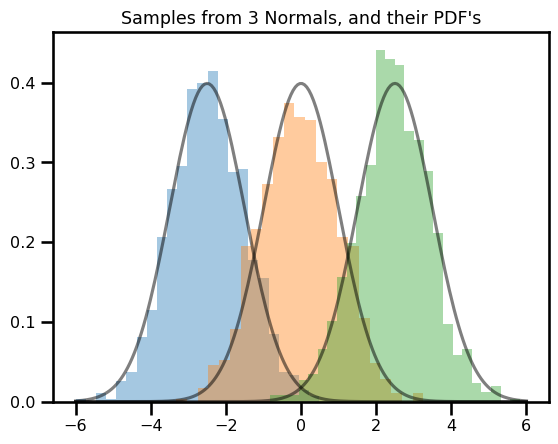

In [15]:
# Summarizing visually
for i in range(3):
  sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

# A vector-variate Distribution

In [16]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [17]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


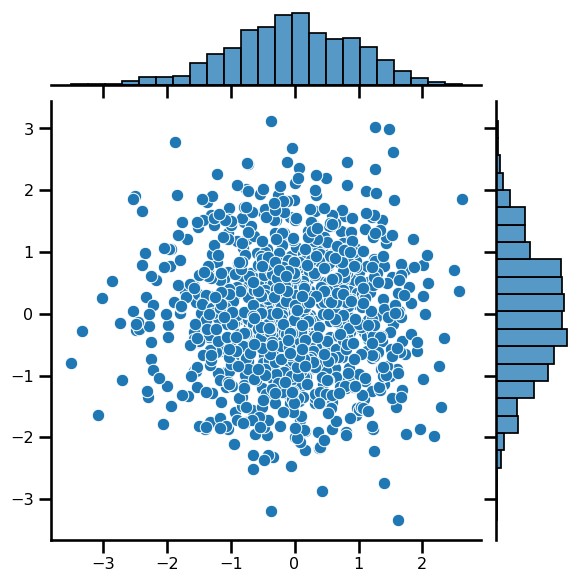

In [18]:
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

# A matrix-variate Distribution

In [19]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print("Batch shape: ", lkj.batch_shape)
print("Event shape: ", lkj.event_shape)

Batch shape:  (2,)
Event shape:  (10, 10)


In [20]:
samples = lkj.sample()
print("Samples shape: ", samples.shape)

2022-08-25 14:53:30.814302: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-25 14:53:30.815136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-25 14:53:30.848249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Samples shape:  (2, 10, 10)


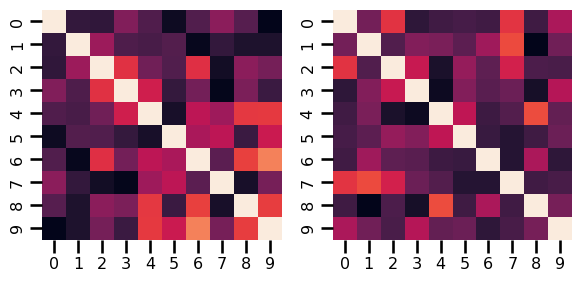

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.heatmap(samples[0, ...], ax=axes[0], cbar=False)
sns.heatmap(samples[1, ...], ax=axes[1], cbar=False)
fig.tight_layout()
plt.show()

# Gaussian Processes

In [22]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


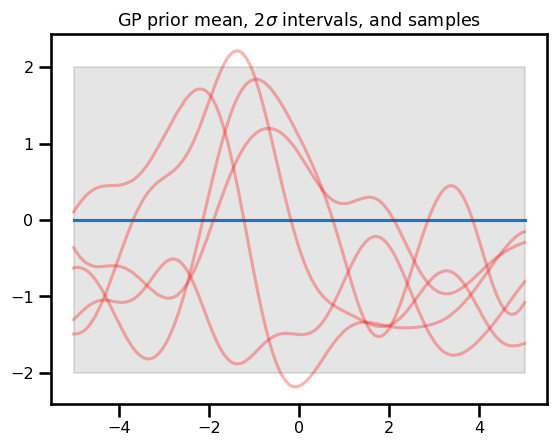

In [23]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gp.sample(), c='r', alpha=.3)
plt.title(r"GP prior mean, $2\sigma$ intervals, and samples")
plt.show()

#    *** Bonus question ***
# Why do so many of these functions lie outside the 95% intervals?

# GP Regression

In [24]:
# Suppose we have some observed data
obs_x = [[-3.], [0.], [2.]]  # Shape 3x1 (3 1-D vectors)
obs_y = [3., -2., 2.]        # Shape 3   (3 scalars)

gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

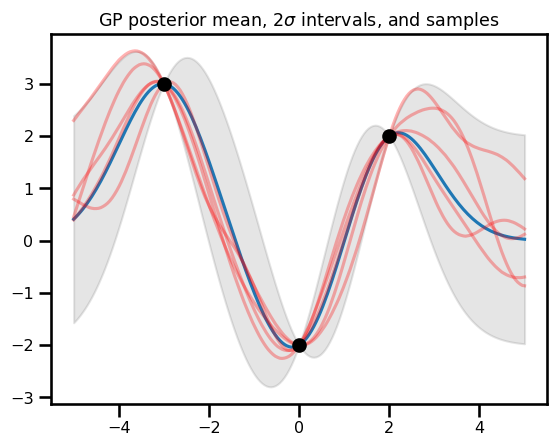

In [25]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title(r"GP posterior mean, $2\sigma$ intervals, and samples")
plt.show()

# Bijectors

Bijectors represent (mostly) invertible, smooth functions. They can be used to transform distributions, preserving the ability to take samples and compute log_probs. They can be in the tfp.bijectors module.

Each bijector implements at least 3 methods:
* forward,
* inverse, and
* (at least) one of forward_log_det_jacobian and inverse_log_det_jacobian.
With these ingredients, we can transform a distribution and still get samples and log probs from the result!

# Caching
Bijectors also cache the forward and inverse computations, and log-det-Jacobians, which allows us to save repeating potentially very expensive operations!

In [26]:
print_subclasses_from_module(tfp.bijectors, tfp.bijectors.Bijector)

AbsoluteValue, Ascending, AutoCompositeTensorBijector, BatchNormalization
Bijector, Blockwise, Chain, CholeskyOuterProduct, CholeskyToInvCholesky
Composition, CorrelationCholesky, Cumsum, DiscreteCosineTransform, Exp, Expm1
FFJORD, FillScaleTriL, FillTriangular, FrechetCDF, GeneralizedExtremeValueCDF
GeneralizedPareto, Glow, GompertzCDF, GumbelCDF, Identity, Inline, Invert
IteratedSigmoidCentered, JointMap, KumaraswamyCDF, LambertWTail, Log, Log1p
MaskedAutoregressiveFlow, MatrixInverseTriL, MatvecLU, MoyalCDF, NormalCDF
Ordered, Pad, Permute, Power, PowerTransform, RationalQuadraticSpline
RayleighCDF, RealNVP, Reciprocal, Reshape, Restructure, Scale, ScaleMatvecDiag
ScaleMatvecLU, ScaleMatvecLinearOperator, ScaleMatvecLinearOperatorBlock
ScaleMatvecTriL, Shift, ShiftedGompertzCDF, Sigmoid, Sinh, SinhArcsinh, SoftClip
Softfloor, SoftmaxCentered, Softplus, Softsign, Split, Square, Tanh
TransformDiagonal, Transpose, WeibullCDF


# A Simple Bijector

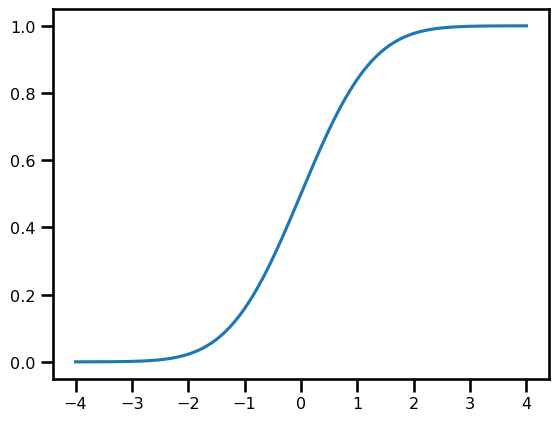

In [27]:
normal_cdf = tfp.bijectors.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.show()

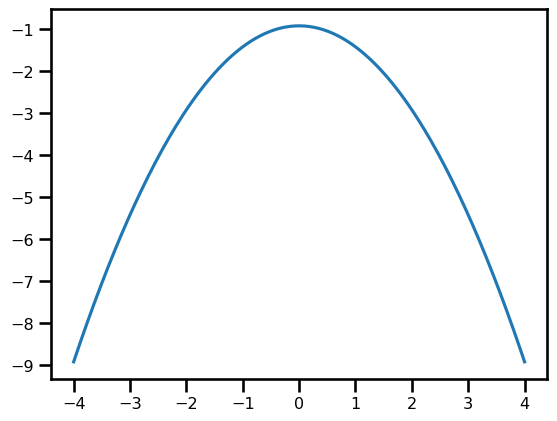

In [28]:
plt.plot(xs, normal_cdf.forward_log_det_jacobian(xs, event_ndims=0))
plt.show()

# A Bijector transforming a Distribution

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


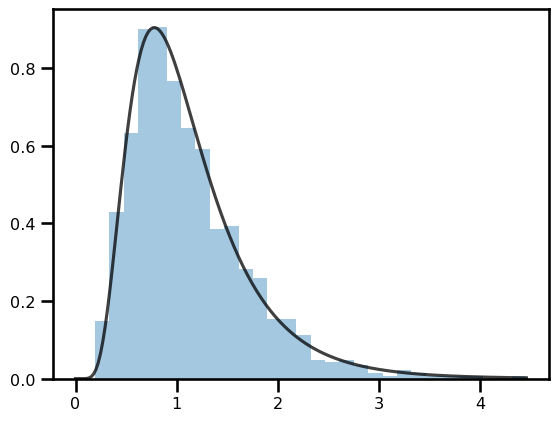

In [29]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
plt.show()

# Batching Bijectors

In [30]:
# Create a batch of bijectors of shape [3,]
softplus = tfp.bijectors.Softplus(
  hinge_softness=[1., .5, .1])
print("Hinge softness shape:", softplus.hinge_softness.shape)

Hinge softness shape: (3,)


In [31]:
# For broadcasting, we want this to be shape [200, 1]
xs = np.linspace(-4., 4., 200)[..., np.newaxis]
ys = softplus.forward(xs)
print("Forward shape:", ys.shape)

Forward shape: (200, 3)


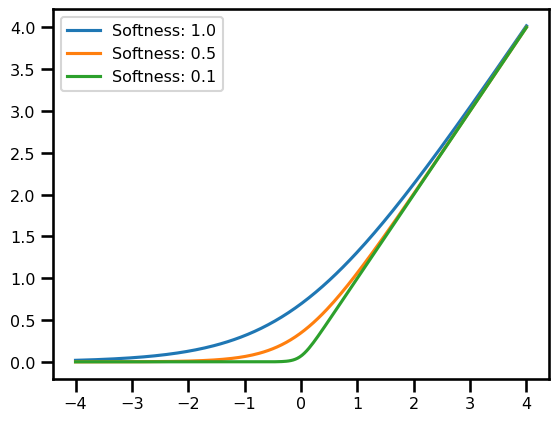

In [32]:
# Visualization
lines = plt.plot(np.tile(xs, 3), ys)
for line, hs in zip(lines, softplus.hinge_softness):
  line.set_label("Softness: %1.1f" % hs)
plt.legend()
plt.show()

# Caching

In [33]:
# This bijector represents a matrix outer product on the forward pass,
# and a cholesky decomposition on the inverse pass. The latter costs O(N^3)!
bij = tfb.CholeskyOuterProduct()

size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

# Caching for the win!
%timeit bij.inverse(big_positive_definite)
%timeit tf.linalg.cholesky(big_positive_definite)

52.3 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
93.4 ms ± 809 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# MCMC
TFP has built in support for some standard Markov chain Monte Carlo algorithms, including Hamiltonian Monte Carlo.

# Generate a data set

In [34]:
# Generate some data
def f(x, w):
  # Pad x with 1's so we can add bias via matmul
  x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
  linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
  result = linop.matmul(x, adjoint=True)
  return result[..., 0, :]

num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w) + np.random.normal(0., noise_scale, size=num_examples)

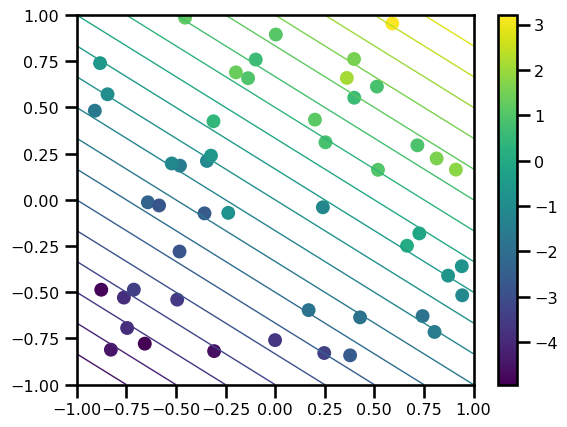

In [35]:
# Visualize the data set
plt.scatter(*xs, c=ys, s=100, linewidths=0)

grid = np.meshgrid(*([np.linspace(-1, 1, 100)] * 2))
xs_grid = np.stack(grid, axis=0)
fs_grid = f(xs_grid.reshape([num_features, -1]), true_w)
fs_grid = np.reshape(fs_grid, [100, 100])
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)
plt.show()

# Define our joint log-prob function
The unnormalized posterior is the result of closing over the data to form a partial application of the joint log prob.

In [36]:
# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(num_features + 1),
    scale_diag=np.ones(num_features + 1))

  rv_y = tfd.Normal(f(x, w), noise_scale)
  return (rv_w.log_prob(w) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))

In [37]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w):
  return joint_log_prob(w, xs, ys)

# Build HMC TransitionKernel and call sample_chain

In [38]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [39]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.

@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [ ]:
initial_state = np.zeros(num_features + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-08-25 14:54:21.157081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Adaptive step sizes
We can wrap our HMC TransitionKernel in a SimpleStepSizeAdaptation "meta-kernel", which will apply some (rather simple heuristic) logic to adapt the HMC step size during burnin. We allot 80% of burnin for adapting step size, and then let the remaining 20% go just to mixing.

In [49]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      hmc_kernel,
      num_adaptation_steps=int(.8 * num_burnin_steps),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [50]:
samples, kernel_results = run_chain(
  initial_state=np.zeros(num_features+1))
print("Acceptance rate:", kernel_results.inner_results.is_accepted.numpy().mean())

2022-08-25 14:42:41.079520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Acceptance rate: 0.65


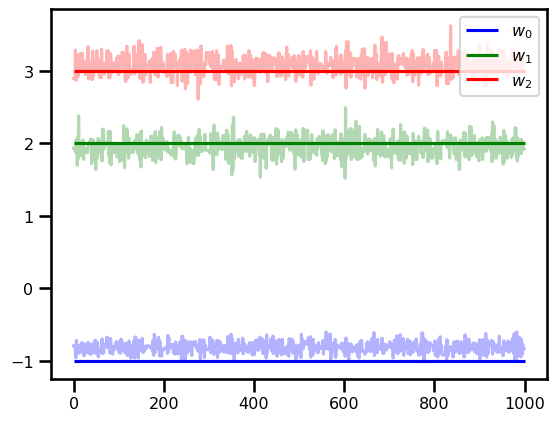

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


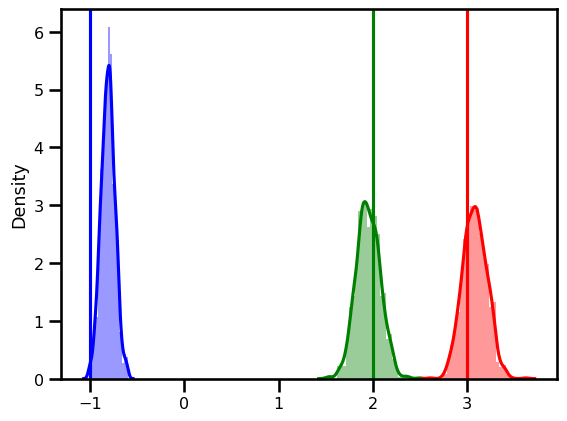

In [51]:
# Trace plots
colors = ['b', 'g', 'r']
for i in range(3):
  plt.plot(samples[:, i], c=colors[i], alpha=.3)
  plt.hlines(true_w[i], 0, 1000, zorder=4, color=colors[i], label="$w_{}$".format(i))
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
for i in range(3):
  sns.distplot(samples[:, i], color=colors[i])
ymax = plt.ylim()[1]
for i in range(3):
  plt.vlines(true_w[i], 0, ymax, color=colors[i])
plt.ylim(0, ymax)
plt.show()